In [208]:
import torch
import sys
sys.path.append('/mnt/data/th')
from models.resnet_fednonlocal import resnet as resnet_nonlocal_server
from models.resnet_fednonlocal import resnet_nonlocal

In [209]:
from models.resnet_fednonlocal import ResnetBlock,NonLocalBlockND,Classfier
from torch import nn

class resnet_nonlocal(nn.Module):
    def __init__(self, blocks=2, input_nc=3, feature_dim=784, net_mode='resnet', in_channels=4, numclass=10) -> None:
        super(resnet_nonlocal, self).__init__()

        self.encoder_local_layer_0 = nn.Sequential(
            nn.Conv2d(input_nc, 16, kernel_size=3, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.encoder_local_layer_1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.encoder_local_layer_2 = ResnetBlock(32, padding_type='reflect',
                                  norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=True)
        
        self.encoder_local_layer_3 = ResnetBlock(32, padding_type='reflect',
                                  norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=True)

        self.encoder_local_layer_4 = nn.Conv2d(32, 4, kernel_size=1)

        self.encoder_new_layer_0 = nn.Sequential(
            nn.Conv2d(input_nc, 16, kernel_size=3, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.encoder_new_layer_1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.encoder_new_layer_2 = ResnetBlock(32, padding_type='reflect',
                                  norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=True)
        
        self.encoder_new_layer_3 = ResnetBlock(32, padding_type='reflect',
                                  norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=True)

        self.encoder_new_layer_4 = nn.Conv2d(32, 4, kernel_size=1)

        self.block = nn.Sequential(
            nn.Tanh()
        )
        self.Nonlocal_1 = NonLocalBlockND(in_channels)
        self.classfier = Classfier(feature_dim, 256, 128)
        self.out = nn.Sequential(
            nn.Linear(128, numclass)
        )

    def forward(self, x):
        
        x_local = self.encoder_local_layer_0(x)
        x_local = self.encoder_local_layer_1(x_local)
        x_local = self.encoder_local_layer_2(x_local)
        x_local = self.encoder_local_layer_3(x_local)
        x_local = self.encoder_local_layer_4(x_local)

        x_new = self.encoder_new_layer_0(x)
        x_new = self.encoder_new_layer_1(x_new)
        x_new = self.encoder_new_layer_2(x_new)
        x_new = self.encoder_new_layer_3(x_new)
        x_new = self.encoder_new_layer_4(x_new)

        x_combine_1 = self.Nonlocal_1(x_new, x_local)

        x_combine_1 = self.block(x_combine_1)

        x_combine_ = torch.flatten(x_combine_1, start_dim=1)
        logs = self.out(self.classfier(x_combine_))

        return logs

    def change_paras(self):
        self.encoder_local.load_state_dict(self.encoder_new.state_dict())


class resnet(nn.Module):
    def __init__(self, blocks=2, input_nc=3, feature_dim=784, net_mode='resnet', in_channels=4, numclass=10, KD=False) -> None:
        super(resnet, self).__init__()

        self.encoder_new_layer_0 = nn.Sequential(
            nn.Conv2d(input_nc, 16, kernel_size=3, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.encoder_new_layer_1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.encoder_new_layer_2 = ResnetBlock(32, padding_type='reflect',
                                  norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=True)
        
        self.encoder_new_layer_3 = ResnetBlock(32, padding_type='reflect',
                                  norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=True)

        self.encoder_new_layer_4 = nn.Conv2d(32, 4, kernel_size=1)

        self.block = nn.Sequential(
            nn.Tanh()
        )
        self.classfier = Classfier(feature_dim, 256, 128)
        self.out = nn.Sequential(
            nn.Linear(128, numclass)
        )
        self.KD = KD
    def forward(self, x):
        x_new = self.encoder_new_layer_0(x)
        x_new = self.encoder_new_layer_1(x_new)
        x_new = self.encoder_new_layer_2(x_new)
        x_new = self.encoder_new_layer_3(x_new)
        x_new = self.encoder_new_layer_4(x_new)
        x_new = self.block(x_new)
        x_combine_ = torch.flatten(x_new, start_dim=1)
        x_f = self.classfier(x_combine_)
        logs = self.out(x_f)
        if self.KD:
            return x_f, logs
        return logs

In [210]:
#创建全局模型

import os

model = resnet(feature_dim=576)

paras_old = model.state_dict()
# print(model.state_dict().keys())

# model_1 = resnet_nonlocal_server(feature_dim=576)
# print(model_1.state_dict().keys())
paras = torch.load("/mnt/data/th/FedAlign/logs/20220825_030130__fednonlocal_e10_c100/server.pt")

for key_old,key_new in zip(paras_old.keys(),paras.keys()):
    paras_old[key_old] = paras[key_new]

model.load_state_dict(paras_old)
# print(paras.keys())
# model.load_state_dict(paras)
# print(model.classfier)

<All keys matched successfully>

In [211]:
#创建本地模型读取参数
local_model = resnet_nonlocal(feature_dim=576)
paras_local = local_model.state_dict()

for key,value in model.state_dict().items():
    if key in paras_local:
        paras_local[key] = value

local_model.load_state_dict(paras_local)

<All keys matched successfully>

In [212]:
#创建数据集划分
from FedTH.data.digits_feature import prepare_feature_data

train_dataloaders, val,test_dataloaders = prepare_feature_data("digits+feature",64,4)

0 current 
current size for 0 is 185
current size for 0 is 185
current size for 0 is 185
current size for 0 is 185
current size for 0 is 185
1 current 
current size for 1 is 185
current size for 1 is 185
current size for 1 is 185
current size for 1 is 185
current size for 1 is 185
2 current 
current size for 2 is 185
current size for 2 is 185
current size for 2 is 185
current size for 2 is 185
current size for 2 is 185
3 current 
current size for 3 is 185
current size for 3 is 185
current size for 3 is 185
current size for 3 is 185
current size for 3 is 185


In [213]:
print(len(train_dataloaders))
train_data = train_dataloaders[0]

20


In [214]:
# #训练本地模型（未利用全局信息）
# # model = resnet_nonlocal_server(feature_dim=576)
# import numpy as np

# device = "cpu" if not torch.cuda.is_available() else "cuda"

# device = torch.device(device)

# local_model.train()

# local_model.to(device)

# loss_func = torch.nn.CrossEntropyLoss()
# optimize = torch.optim.SGD(local_model.parameters() ,lr=0.01)

# for key,paras in local_model.named_parameters():
#     if "encoder_local" in key:
#         paras.requires_grad = False

# for epoch in range(10):
#     losses = []
#     for data,label in train_data:
#         data = data.to(device)
#         label = label.to(device)

#         logits = local_model(data)
#         loss = loss_func(logits,label)
#         loss.backward()
#         losses.append(loss.item())
#         # print("loss:{}".format(loss.item()))

#         optimize.step()
#     losses = np.array(losses)
#     print("loss:{}".format(losses.mean()))


In [215]:
import numpy as np

device = "cpu" if not torch.cuda.is_available() else "cuda"

device = torch.device(device)

loss_func = torch.nn.CrossEntropyLoss()


In [216]:
model_test = resnet(feature_dim=576)

model_test.train()
model_test.to(device)

optimize = torch.optim.SGD(model_test.parameters() ,lr=0.01)


# for key,paras in local_model.named_parameters():
#     if "encoder_local" in key:
#         paras.requires_grad = False

for epoch in range(10):
    losses = []
    for data,label in train_data:
        data = data.to(device)
        label = label.to(device)

        logits = model_test(data)
        loss = loss_func(logits,label)
        loss.backward()
        losses.append(loss.item())
        # print("loss:{}".format(loss.item()))

        optimize.step()
    losses = np.array(losses)
    print("loss:{}".format(losses.mean()))


loss:2.2947874863942466
loss:2.2132845719655356
loss:2.0771918296813965
loss:1.8812493483225505
loss:1.5981007814407349
loss:1.2723294893900554
loss:0.982837955156962
loss:0.7211032708485922
loss:0.45570943752924603
loss:0.2744227945804596


In [217]:
paras = local_model.state_dict()

for key,value in model_test.state_dict().items():
    if "new" in key:
        key_new = key.replace("new","local")
        if "encoder" in key:
            paras[key_new] = value


In [218]:


optimize = torch.optim.SGD(local_model.parameters() ,lr=0.01)


local_model.train()

local_model.to(device)

# for key,paras in local_model.named_parameters():
#     if "encoder_local" in key:
#         paras.requires_grad = False

for epoch in range(10):
    losses = []
    for data,label in train_data:
        data = data.to(device)
        label = label.to(device)

        logits = local_model(data)
        loss = loss_func(logits,label)
        loss.backward()
        losses.append(loss.item())
        # print("loss:{}".format(loss.item()))

        optimize.step()
    losses = np.array(losses)
    print("loss:{}".format(losses.mean()))


loss:0.19248749564091364
loss:0.08686068405707677
loss:0.02703664420793454
loss:0.027423510948816936
loss:0.035178675005833306
loss:0.021212950348854065
loss:0.018091759644448757
loss:0.01598774300267299
loss:0.014820147305727005
loss:0.02919332046682636


In [219]:
from torchvision import transforms

transform_mnist = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

from FedBN.utils.data_utils import DigitsDataset

mnist_trainset = DigitsDataset(data_path="/mnt/data/th/FedBN/data/MNIST", channels=1, percent=0.1, train=True,  transform=transform_mnist)

imagenet_class_labels = {}

for index,(data,label) in enumerate(zip(mnist_trainset.images,mnist_trainset.labels)):
    imagenet_class_labels.update({index:label})

print(imagenet_class_labels)

{0: 9, 1: 9, 2: 2, 3: 0, 4: 9, 5: 6, 6: 0, 7: 9, 8: 3, 9: 3, 10: 1, 11: 6, 12: 5, 13: 5, 14: 2, 15: 6, 16: 6, 17: 3, 18: 4, 19: 7, 20: 8, 21: 8, 22: 7, 23: 4, 24: 2, 25: 8, 26: 0, 27: 7, 28: 8, 29: 7, 30: 5, 31: 3, 32: 3, 33: 9, 34: 3, 35: 1, 36: 3, 37: 6, 38: 7, 39: 4, 40: 7, 41: 4, 42: 1, 43: 6, 44: 4, 45: 2, 46: 4, 47: 6, 48: 1, 49: 8, 50: 1, 51: 8, 52: 6, 53: 5, 54: 6, 55: 3, 56: 8, 57: 2, 58: 5, 59: 6, 60: 6, 61: 0, 62: 0, 63: 1, 64: 9, 65: 8, 66: 3, 67: 6, 68: 1, 69: 5, 70: 0, 71: 9, 72: 9, 73: 5, 74: 3, 75: 0, 76: 5, 77: 7, 78: 3, 79: 4, 80: 8, 81: 5, 82: 3, 83: 0, 84: 7, 85: 1, 86: 1, 87: 1, 88: 3, 89: 0, 90: 0, 91: 7, 92: 1, 93: 1, 94: 9, 95: 8, 96: 0, 97: 7, 98: 9, 99: 4, 100: 6, 101: 2, 102: 4, 103: 0, 104: 3, 105: 1, 106: 0, 107: 1, 108: 8, 109: 6, 110: 7, 111: 0, 112: 4, 113: 6, 114: 2, 115: 5, 116: 0, 117: 2, 118: 3, 119: 1, 120: 7, 121: 8, 122: 5, 123: 6, 124: 3, 125: 2, 126: 6, 127: 6, 128: 0, 129: 6, 130: 1, 131: 0, 132: 7, 133: 0, 134: 0, 135: 6, 136: 6, 137: 9, 138: 

In [189]:
print(local_model)

resnet_nonlocal(
  (encoder_local_layer_0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_local_layer_1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_local_layer_2): ResnetBlock(
    (conv_block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (encoder_local_layer_3): ResnetBlock(
    (conv_

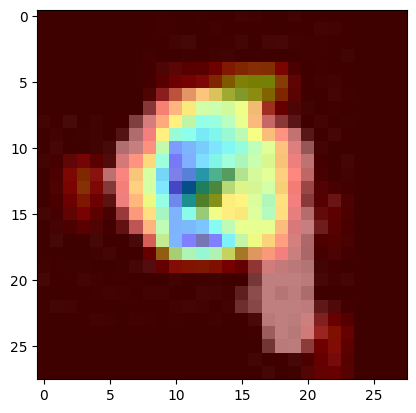

In [223]:
from explainable_cnn import CNNExplainer

x_cnn = CNNExplainer(model_test, imagenet_class_labels)

# image = mnist_trainset.images[0]

# toPIL = transforms.ToPILImage()

# pic = toPIL(image)

# pic.save('9.jpg')

import matplotlib.pyplot as plt
%matplotlib inline

# plt.imshow(pic)
grad_cams  = x_cnn.get_grad_cam(
    "./9.jpg",
    3, # La    bel corresponding to Shark. You can pass either 3 or "tiger shark, Galeocerdo cuvieri",
    (28, 28),
    ["encoder_new_layer_4"]#,"encoder_local_layer_4","Nonlocal_1"
)

plt.imshow(grad_cams[0].astype('uint8'))
plt.show()
# plt.imshow(grad_cams[1].astype('uint8'))
# plt.show()
# plt.imshow(grad_cams[2].astype('uint8'))
# plt.show()

In [102]:
from torchvision import models

model = models.resnet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
from models.resnet import resnet56

model = resnet56(10, KD=True, projection=True)

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru